# Install Libraries

In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install sentence_transformers
!pip install numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from numba import cuda
import pandas as pd
import numpy as np
from transformers import DataCollatorForSeq2Seq
from transformers import TFAutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from datasets import Dataset
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import create_optimizer
from tqdm import tqdm
import gc
from transformers import get_scheduler
from torch.optim import AdamW
import torch.cuda
from google.colab import runtime

## Preprocessing

In [ ]:
# Mount drive
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Import and visualize data
data = pd.read_csv('/content/Embedded_Lies_for_ML.csv', sep = ';', encoding = 'UTF-8')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (2084, 4)


,Participant_id,Stand_num_embedded_lies,Condition,Event
0,660687a02630547fb296d754,0.192708,0,I was in a city nearby my hometown. I was goin...
1,65391353897d68dd53a067da,0.204082,0,It was a 5 year relationship and we were very ...
2,615b2ee8616d1b05551794ee,0.705882,0,It was on the 14th of February when I walked i...
3,616dc201c0b58a25890f4b94,0.545455,0,My partner and I were in a long distance relat...
4,5b6034ba0ced0a00017ba9b9,0.166667,0,we had to plan a celebration for our departmen...


In [ ]:
data['Condition'] = data['Condition'].map({0:'Truthful', 1:'Deceptive'})

In [ ]:
from sklearn.model_selection import train_test_split, GroupKFold
import pandas as pd
import numpy as np

def create_dataset(data, seed=42, cv=5):
    np.random.seed(seed)

    # Initialize train and test dictionaries
    train = {f'split_{i+1}': [] for i in range(cv)}
    test = {f'split_{i+1}': [] for i in range(cv)}

    # Get participant IDs as groups
    participant_ids = data['Participant_id'].unique()

    # Cross-validation using GroupKFold
    group_kfold = GroupKFold(n_splits=cv)

    for i, (train_idx, test_idx) in enumerate(group_kfold.split(data, groups=data['Participant_id'])):
      train_participants = participant_ids[np.intersect1d(train_idx, np.arange(len(participant_ids)))]
      test_participants = participant_ids[np.intersect1d(test_idx, np.arange(len(participant_ids)))]

      # Create train and test sets based on Participant_id
      train[f'split_{i+1}'] = data[data['Participant_id'].isin(train_participants)]
      test[f'split_{i+1}'] = data[data['Participant_id'].isin(test_participants)]

    return train, test

In [ ]:
def preprocess_function(examples):
    inputs = [ex for ex in examples["Event"]]
    targets = [ex for ex in examples["Condition"]]
    model_inputs = tokenizer(
        inputs, text_target=targets, truncation=True)
    return model_inputs

## Base model

In [ ]:
# Define parameters
seed=42
np.random.seed(seed)
collect_result={}
numcv=5
num_epochs = 3
model_size='base'
dataset = data
results={}
preds={}
trus={}

# Train-test split for cross validation
train, test = create_dataset(data, seed=seed, cv=numcv)

# Loop over each split in the cross-validation
for sp in tqdm(train.keys()):

  data_train = Dataset.from_pandas(train[sp])
  data_test = Dataset.from_pandas(test[sp])

  # Load the pre-trained model and tokenizer
  checkpoint = f"google/flan-t5-{model_size}"
  tokenizer = AutoTokenizer.from_pretrained(checkpoint)
  model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

  # Apply preprocessing to the datasets
  data_train = data_train.map(preprocess_function, batched=True)
  data_test = data_test.map(preprocess_function, batched=True)

  # Define the data collator for padding and batching
  data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

  # Set training arguments
  training_args = Seq2SeqTrainingArguments(
      output_dir=f"Flan-T5-{model_size}",
      evaluation_strategy='epoch',
      learning_rate=5e-5,
      per_device_train_batch_size=2,
      weight_decay=0.01,
      save_total_limit=3,
      num_train_epochs=num_epochs,
      predict_with_generate=True,
      fp16=False,
      push_to_hub=False,
      run_name=f"Flan-T5-{model_size}-{sp}",
      report_to=[]
  )

  # Initialize the trainer, then train the model on current split
  trainer = Seq2SeqTrainer(
      model=model,
      args=training_args,
      train_dataset=data_train,
      eval_dataset = data_test,
      tokenizer=tokenizer,
      data_collator=data_collator
  )

  trainer.train()

  # Generate predictions
  pred = []
  for i  in test[sp]['Event']:
    toki = tokenizer(i,  return_tensors="pt").input_ids
    model_output = model.generate(toki.cuda(), return_dict_in_generate=True, output_scores=True)
    decoded_preds = tokenizer.batch_decode(model_output.sequences, skip_special_tokens=True)
    pred.append(decoded_preds[0])
  pred = np.array(pred)

  # Store predictions and ground-truth values
  preds[sp] = pred
  trus[sp] = np.array(test[sp]['Condition'])

  # Collect results in a DF for the current split
  collect_result[sp]=pd.DataFrame.from_dict({
      "Participant_id": test[sp]["Participant_id"],
      "Split": sp,
      "Prediction": pred,
      "Condition": np.array(test[sp]["Condition"])})
  collect_result[sp]['Correct_predictions'] = collect_result[sp]['Prediction'] == collect_result[sp]['Condition']
  results[sp] = [(pred == trus[sp]).mean()]

  # Clear the model from memory after each split
  del model
  del trainer
  torch.cuda.empty_cache()

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/1664 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-48e5dff1e409>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.480700,0.205827
2,0.228700,0.210480
3,0.199900,0.256191


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.
Token indices sequence length is longer than the specified maximum sequence length for this model (644 > 512). Running this sequence through the model will result in indexing errors
 20%|██        | 1/5 [13:49<55:19, 829.80s/it]

Map:   0%|          | 0/1664 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-48e5dff1e409>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.473700,0.220452
2,0.229400,0.264495
3,0.195600,0.286098


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (897 > 512). Running this sequence through the model will result in indexing errors
 40%|████      | 2/5 [31:44<48:41, 973.96s/it]

Map:   0%|          | 0/1664 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-48e5dff1e409>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.475600,0.214754
2,0.227900,0.228951
3,0.204000,0.274718


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (666 > 512). Running this sequence through the model will result in indexing errors
 60%|██████    | 3/5 [46:19<30:56, 928.49s/it]

Map:   0%|          | 0/1664 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-48e5dff1e409>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.490100,0.258766
2,0.227100,0.244585
3,0.197600,0.284123


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (651 > 512). Running this sequence through the model will result in indexing errors
 80%|████████  | 4/5 [1:00:13<14:51, 891.17s/it]

Map:   0%|          | 0/1664 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-48e5dff1e409>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.476400,0.222583
2,0.226300,0.240512
3,0.200700,0.267337


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors
100%|██████████| 5/5 [1:17:39<00:00, 931.84s/it]

Average accuracy:  0    0.597596
dtype: float64
Standard deviation of accuracy:  0    0.016532
dtype: float64
Max accuracy:  0    0.617788
dtype: float64
Min deviation of accuracy:  0    0.581731
dtype: float64


In [ ]:
# Compile results from all splits and concatenate them into a dataset
results = pd.DataFrame.from_dict(results)
print('Average accuracy: ', results.mean(axis=1))
print('Standard deviation of accuracy: ', results.std(axis=1))
print('Max accuracy: ', results.max(axis=1))
print('Min deviation of accuracy: ', results.min(axis=1))
show_result = pd.concat(collect_result.values(), keys=collect_result.keys())
show_result = show_result.droplevel(1)

Average accuracy:  0    0.597596
dtype: float64
Standard deviation of accuracy:  0    0.016532
dtype: float64
Max accuracy:  0    0.617788
dtype: float64
Min deviation of accuracy:  0    0.581731
dtype: float64


In [ ]:
show_result

,Prediction,Condition,Participant_id,Split,Correct_predictions
split_1,Truthful,Truthful,5fbbde667818f3dc301f6647,split_1,True
split_1,Deceptive,Truthful,6133d6ceda5d8d0022d8b108,split_1,False
split_1,Truthful,Truthful,613644ab1f992400aacf1ddf,split_1,True
split_1,Deceptive,Truthful,5ea63c3594a32d64240bf2ea,split_1,False
split_1,Truthful,Truthful,652bea56d7736bf02261d534,split_1,True
...,...,...,...,...,...
split_5,Truthful,Deceptive,615ac7798523e99c564cd526,split_5,False
split_5,Deceptive,Deceptive,60e6e0c1bdc21718b253baf2,split_5,True
split_5,Deceptive,Deceptive,611d14372f0789675dc47b76,split_5,True
split_5,Deceptive,Deceptive,66338fe753a8d92b773d1050,split_5,True


In [ ]:
show_result.to_csv('/content/10cv_results_embedded_lies.csv', sep=';', index=False)

## Analyse performance


Explore correct and incorrect classification. Is there a significant difference in the number of embedded lies?

In [ ]:
# Import and visualize data
import pandas as pd
import numpy as np

results = pd.read_csv('/content/10cv_results_embedded_lies.csv', sep = ';', encoding = 'UTF-8')
print(f"Dataset shape: {results.shape}")
results.head()

Dataset shape: (2080, 5)


,Participant_id,Split,Prediction,Condition,Correct_predictions
0,5fbbde667818f3dc301f6647,split_1,Truthful,Truthful,True
1,6133d6ceda5d8d0022d8b108,split_1,Deceptive,Truthful,False
2,613644ab1f992400aacf1ddf,split_1,Truthful,Truthful,True
3,5ea63c3594a32d64240bf2ea,split_1,Deceptive,Truthful,False
4,652bea56d7736bf02261d534,split_1,Truthful,Truthful,True


In [ ]:
results.shape

(2080, 5)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Placeholder for storing scores for each split
scores_per_split = []
accuracy_per_split = []

# Unique splits
unique_splits = results['Split'].unique()

# Iterate through each split
for split in unique_splits:
    split_data = results[results['Split'] == split]

    # Compute classification report for the current split
    report = classification_report(
        split_data['Condition'],
        split_data['Prediction'],
        target_names=['Deceptive', 'Truthful'],
        output_dict=True
    )

    # Append metrics for this split
    scores_per_split.append({
        "Truthful_precision": report['Truthful']['precision'],
        "Truthful_recall": report['Truthful']['recall'],
        "Truthful_f1": report['Truthful']['f1-score'],
        "Deceptive_precision": report['Deceptive']['precision'],
        "Deceptive_recall": report['Deceptive']['recall'],
        "Deceptive_f1": report['Deceptive']['f1-score'],
        "macro_precision": report['macro avg']['precision'],
        "macro_recall": report['macro avg']['recall'],
        "macro_f1": report['macro avg']['f1-score'],
        "weighted_precision": report['weighted avg']['precision'],
        "weighted_recall": report['weighted avg']['recall'],
        "weighted_f1": report['weighted avg']['f1-score'],
        "accuracy": report['accuracy']
    })
    accuracy_per_split.append(report['accuracy'])

# Convert scores to a DataFrame for easier averaging
scores_df = pd.DataFrame(scores_per_split)

# Compute average and standard deviation for each metric
average_scores = scores_df.mean()
std_scores = scores_df.std()

# Format output as a summary table
summary_table = pd.DataFrame({
    "Metric": average_scores.index,
    "Average": average_scores.values,
    "Standard Deviation": std_scores.values
})

# Display average classification report with standard deviation
print("\nAverage Classification Report with Standard Deviation:")
print("Label           Precision       Recall          F1-score")
print("=" * 60)
for label in ["Truthful", "Deceptive", "macro", "weighted"]:
    precision_avg = average_scores[f"{label}_precision"]
    precision_std = std_scores[f"{label}_precision"]
    recall_avg = average_scores[f"{label}_recall"]
    recall_std = std_scores[f"{label}_recall"]
    f1_avg = average_scores[f"{label}_f1"]
    f1_std = std_scores[f"{label}_f1"]
    print(
        f"{label:<15} {precision_avg:.3f} (±{precision_std:.3f})  "
        f"{recall_avg:.3f} (±{recall_std:.3f})  "
        f"{f1_avg:.3f} (±{f1_std:.3f})"
    )

# Print overall averaged metrics
accuracy_avg = np.mean(accuracy_per_split)
accuracy_std = np.std(accuracy_per_split)
print(f"Averaged accuracy: {accuracy_avg:.3f} (±{accuracy_std:.3f})")


Average Classification Report with Standard Deviation:
Label           Precision       Recall          F1-score
Truthful        0.605 (±0.062)  0.569 (±0.031)  0.585 (±0.031)
Deceptive       0.593 (±0.035)  0.629 (±0.042)  0.609 (±0.012)
macro           0.599 (±0.019)  0.599 (±0.018)  0.597 (±0.017)
weighted        0.602 (±0.020)  0.598 (±0.017)  0.598 (±0.016)
Averaged accuracy: 0.598 (±0.015)


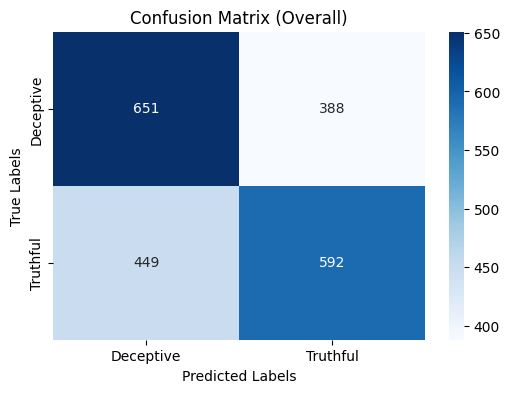

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(results['Condition'], results['Prediction'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Deceptive', 'Truthful'], yticklabels=['Deceptive', 'Truthful'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Overall)')
plt.show()

In [ ]:
# Merge the two datasets
merged_df = pd.merge(data, results, on=['Participant_id', 'Condition'], how='inner')
merged_df

,Participant_id,Stand_num_embedded_lies,Condition,Event,Split,Prediction,Correct_predictions
0,660687a02630547fb296d754,0.192708,Truthful,I was in a city nearby my hometown. I was goin...,split_4,Deceptive,False
1,65391353897d68dd53a067da,0.204082,Truthful,It was a 5 year relationship and we were very ...,split_5,Truthful,True
2,615b2ee8616d1b05551794ee,0.705882,Truthful,It was on the 14th of February when I walked i...,split_2,Deceptive,False
3,616dc201c0b58a25890f4b94,0.545455,Truthful,My partner and I were in a long distance relat...,split_3,Deceptive,False
4,5b6034ba0ced0a00017ba9b9,0.166667,Truthful,we had to plan a celebration for our departmen...,split_4,Truthful,True
...,...,...,...,...,...,...,...
2079,60fbf1d8a1d6bf084f981660,0.259681,Deceptive,coming back from work on the day of losing her...,split_2,Deceptive,True
2080,611acc1d8ef0468018d77f76,0.718919,Deceptive,"The day was 7 january 2024, it was a Sunday. T...",split_3,Deceptive,True
2081,661624e5595c233a68a3963b,0.019934,Deceptive,I was given a specific task at work by a consu...,split_2,Deceptive,True
2082,658c1f91c0e5d908b094430e,0.184783,Deceptive,It was because of a close experience with my f...,split_5,Truthful,False


In [ ]:
merged_df.to_csv('results_merged.csv', sep = ';', index = False)